# Comparison between SVD and Lanczos

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fastsst import SingularSpectrumTransformation

In [2]:
np.random.seed(123)

In [3]:
def plot_data_and_score(raw_data, score):
    f, ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(raw_data); ax[0].set_title("raw data")
    ax[1].plot(score,"r"); ax[1].set_title("score")

In [4]:
# synthetic (step function)
x0 = 1 * np.ones(1000) + np.random.rand(1000) * 1
x1 = 3 * np.ones(1000) + np.random.rand(1000) * 2
x2 = 5 * np.ones(1000) + np.random.rand(1000) * 1.5
x = np.hstack([x0, x1, x2])
x +=  + np.random.rand(x.size)

## Calculation speed
* We focus on only window length which is the most factor affects on calculation speed.
* Longer window length, SVD takes much longer compute time.

In [5]:
# run once in advance for jit compilation
SingularSpectrumTransformation(30).score_offline(x);

In [6]:
from timeit import default_timer


def measure_calc_time(x, param, n_iter=10):
    """Measure calculation time."""
    sst = SingularSpectrumTransformation(**param)
    
    res = []
    for i in range(n_iter):
        start = default_timer()
        sst.score_offline(x)
        end = default_timer()
        res.append(end - start)
    return sum(res) / len(res)

In [7]:
win_lengths_candidates = np.logspace(1,3,5).astype(int)

In [8]:
methods = []; times = []; win_lengths = [];

for method in ("svd","lanczos"):
    for wl in win_lengths_candidates:
        for j in range(10):
            param = {
                "win_length": int(wl),
                "use_lanczos": True if method == "lanczos" else False
            }
            times.append(measure_calc_time(x, param, n_iter=1))
            methods.append(method)
            win_lengths.append(wl)

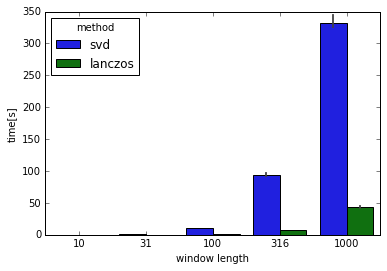

In [12]:
df = pd.DataFrame({
    "time[s]":times, "method":methods, "window length":win_lengths})
sns.barplot(x="window length", y="time[s]", hue="method", data=df)

## Change-point score
* Basically, the Lanczos score doesn't coincide with SVD score because the both definitions of change point score used in this package are different  
(see [references](https://github.com/statefb/singular-spectrum-transformation#references)).  
* SVD score definition takes into consideration multiple rank of test Hankel matrix(the rank is user-specified by `n_components`) meanwhile Lanczos score only takes the first left-singular vector.  
* It's hard to tell which definition is better since it depends on the application. In some cases we may have to choose carefully as well as other parameters, but practically it's enough to use Lanczos method. [see examples](https://github.com/statefb/singular-spectrum-transformation/blob/master/notebooks/examples.ipynb).

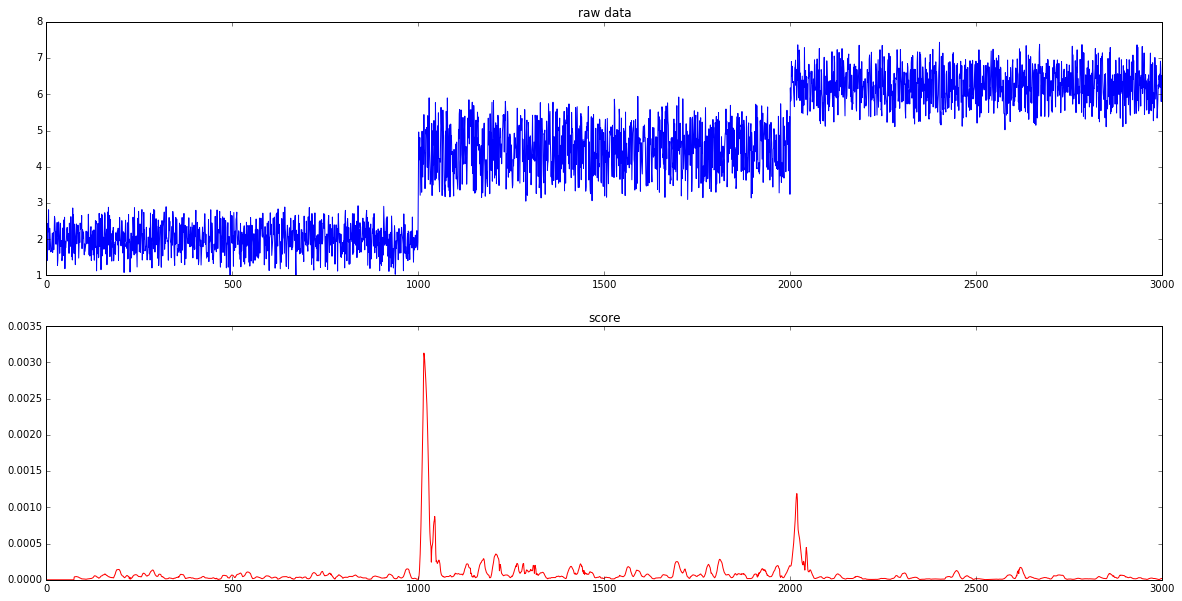

In [15]:
# Lanczos
score = SingularSpectrumTransformation(win_length=30, n_components=2, use_lanczos=True).score_offline(x)
plot_data_and_score(x,score)

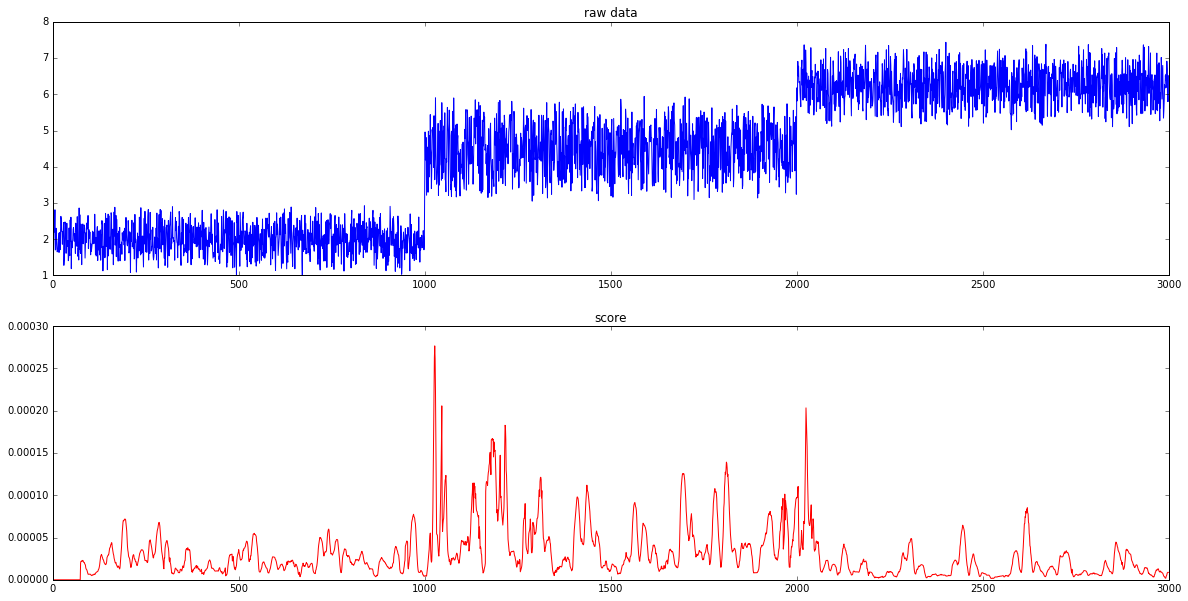

In [16]:
# SVD
score = SingularSpectrumTransformation(win_length=30, n_components=2, use_lanczos=False).score_offline(x)
plot_data_and_score(x,score)  # doesn't match above change-point score!

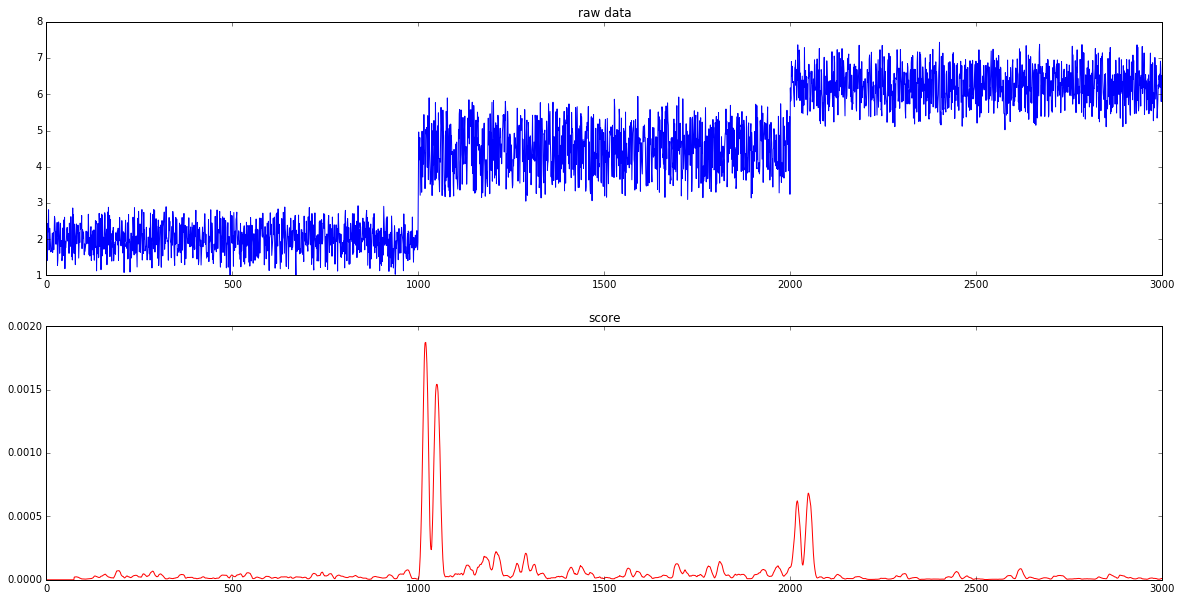

In [17]:
# SVD with lower n_components
score = SingularSpectrumTransformation(win_length=30, n_components=1, use_lanczos=False).score_offline(x)
plot_data_and_score(x,score)  # in the case of this data, lower `n_components` yields good result